In [1]:
import json
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

In [4]:
def flatten(l):
  return [item for sublist in l for item in sublist]

In [3]:

class ServerInformation:
  def __init__(self, server):
    self.config = server.config
    self.num_epochs = server.config["global_epochs"]
    self.local_accuracies = {
        client.id: client.data_frame.Accuracy.tolist() for client in server.clients
    }
    # {
    #     1 : [0.1, 0.2, ...]
    # }
    self.local_sensitivities = {
        client.id: client.data_frame.Sensitivity.tolist() for client in server.clients
    }
    self.local_specificities = {
        client.id: client.data_frame.Specificity.tolist() for client in server.clients
    }
    self.local_f1_scores = {
        client.id: client.data_frame.F1Score.tolist() for client in server.clients
    }

    self.clients_average_losses = {
        client.id: client.data_frame.Loss.tolist() for client in server.clients
    }
    self.trained = server.trained
    self.val_losses = {
        client.id: client.data_frame.ValLoss.tolist() for client in server.clients
    }
    # print(server.global_results_dict)
    self.global_accuracies = [[client['accuracy'] for client in group.values()] for group in server.global_results_dict.values()]
    self.global_specifcities = [[np.mean(client['specificity']) for client in group.values()] for group in server.global_results_dict.values()]
    self.global_sensitivities = [[np.mean(client['sensitivity']) for client in group.values()] for group in server.global_results_dict.values()]
    self.global_f1_scores = [[np.mean(client['f1_score']) for client in group.values()] for group in server.global_results_dict.values()]
    

  def compute_average(self, evaluation_metric_name, epoch):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if evaluation_metric_name == 'accuracy':
      evaluation_metric = self.local_accuracies

    elif evaluation_metric_name == 'sensitivity':
      evaluation_metric = self.local_sensitivities

    elif evaluation_metric_name == 'specificity':
      evaluation_metric = self.local_specificities

    elif 'f1' in evaluation_metric_name:
      evaluation_metric = self.local_f1_scores

    elif 'val' in evaluation_metric_name:
      evaluation_metric = self.val_losses
      
    elif 'loss' in evaluation_metric_name:
      evaluation_metric = self.clients_average_losses
      
    else:
      print('Metric doesnt exist')
    average = 0.0
    for i in self.trained[epoch]:
      average += np.mean(evaluation_metric[i][epoch])
    return average / len(self.trained[epoch])

  def get_average(self, evaluation_metric_name):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if evaluation_metric_name == 'accuracy':
      evaluation_metric = self.local_accuracies
      title = "Local accuracy during training"
      metric = "accuracy"
    
    elif evaluation_metric_name == 'sensitivity':
      evaluation_metric = self.local_sensitivities
      title = "Local senstivities during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "sensitivity"
      ylim = (0,1.1)
    
    elif evaluation_metric_name == 'specificity':
      evaluation_metric = self.local_specificities
      title = "Local specificities during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "specificity"
      ylim = (0,1.1)
    
    elif 'f1' in evaluation_metric_name:
      evaluation_metric = self.local_f1_scores
      title = "Local f1-score during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "f1-score"

    elif 'val' in evaluation_metric_name:
      evaluation_metric = self.val_losses
      metric = "Validation Loss"

    elif 'loss' in evaluation_metric_name:
      evaluation_metric = self.clients_average_losses
      metric = "Loss"
    
    elif 'acc' in evaluation_metric_name and 'global' in evaluation_metric_name:
      evaluation_metric = self.global_accuracy
    
    else:
      print('Metric doesnt exist')
      print(evaluation_metric_name)
      return
    arr_to_return = []
    for i, trained in enumerate(self.trained):
      round_value = []
      for client in trained:
        round_value.append(evaluation_metric[client][i])
      arr_to_return.append(np.mean([np.mean(i) for i in round_value]))

    return arr_to_return

  def plot_average(self, evaluation_metric_name, std=False):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if "global" not in evaluation_metric_name:
      if evaluation_metric_name == 'accuracy':
        evaluation_metric = self.local_accuracies
        title = "Local accuracy during training"
        metric = "accuracy"

      elif evaluation_metric_name == 'sensitivity':
        evaluation_metric = self.local_sensitivities
        title = "Local senstivities during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "sensitivity"
        ylim = (0,1.1)

      elif evaluation_metric_name == 'specificity':
        evaluation_metric = self.local_specificities
        title = "Local specificities during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "specificity"
        ylim = (0,1.1)

      elif 'f1' in evaluation_metric_name:
        evaluation_metric = self.local_f1_scores
        title = "Local f1-score during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "f1-score"
        ylim = (0,1.1)

      elif 'val' in evaluation_metric_name:
        evaluation_metric = self.val_losses
        title = "Local validation loss during training"
        metric = "Validation Loss"

      elif 'loss' in evaluation_metric_name:
        evaluation_metric = self.clients_average_losses
        title = "Average Loss during training"
        metric = "Loss"
    elif "global" in evaluation_metric_name:
        if 'acc' in evaluation_metric_name:
          evaluation_metric = self.global_accuracies
          title = "Global accuracy during training"
          ylabel = "Accuracy"
        elif 'speci' in evaluation_metric_name:
          evaluation_metric = self.global_specifcities
          title = "Global specificity during training"
          ylabel = "Specificity"
          ylim = (0, 1.1)
        elif 'sensit' in evaluation_metric_name:
          evaluation_metric = self.global_sensitivities
          title = "Global sensitivity during training"
          ylabel = "Sensitivity"
          ylim = (0, 1.1)
        elif 'f1' in evaluation_metric_name:
          evaluation_metric = self.global_f1_scores
          title = "Global f1-scores during training"
          ylabel = "f1-scores"
          ylim = (0, 1.1)
        else:
          print(f'Metric {evaluation_metric_name} doesnt exist')
          return
        
        if std:
          print("we only have the average values, no std ")
        evaluation_metric = np.array(evaluation_metric).mean(axis=0)
        print(np.array(evaluation_metric).shape)
        fig = plt.figure()
        plt.figure(figsize=(10,8))
        plt.plot(list(range(len(evaluation_metric))), evaluation_metric, label=title)
        plt.title(title)
        plt.xlabel("Training Epochs")
        plt.ylabel(ylabel)
        # Add a grid with custom colors
        plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
        plt.legend()
        ax = plt.gca()
        ax.set_facecolor((0,0,0,0.05))
        ax.set_xticks(list(range(0,len(evaluation_metric), len(evaluation_metric) // 4)))
        try:
          plt.ylim(*ylim)
        except NameError:
          pass
        plt.xlim(0, len(evaluation_metric)-1)
        plt.show()
        return
    else:
      print(f'Metric {evaluation_metric_name} doesnt exist')
      return
    # evaluation_metric = np.array(list(evaluation_metric.values()))
    arr_to_plot = []
    if std:
      std_values = []
    for i, trained in enumerate(self.trained):
      round_value = []
      for client in trained:
        round_value.append(evaluation_metric[client][i])
      if std:
        std_values.append(np.std(round_value))
      arr_to_plot.append(np.mean(round_value))
    
    if std:
      std_values = np.array(std_values)
      upper = arr_to_plot + std_values
      lower = arr_to_plot - std_values
    
    fig = plt.figure()
    plt.figure(figsize=(10,8))
    plt.plot(list(range(len(arr_to_plot))), arr_to_plot, label=title)
    if std:
      plt.fill_between(list(range(len(arr_to_plot))),upper, lower, color="C0", alpha=0.3, label="std of "+ title)
    plt.title(title)
    plt.xlabel("Training Epochs")
    plt.ylabel(metric)
    # Add a grid with custom colors
    plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
    plt.legend()
    ax = plt.gca()
    ax.set_facecolor((0,0,0,0.05))
    ax.set_xticks(list(range(0,len(arr_to_plot), len(arr_to_plot) // 4)))
    if std:
      plt.ylim(0, max(upper)+0.1)
    else:
      try:
        plt.ylim(*ylim)
      except NameError:
        pass
    plt.xlim(0, len(arr_to_plot)-1)
    plt.show()

  def summary_dict(self):
    return {
          "local_accuracies": self.get_average('accuracy'),
          "local_sensitivities": self.get_average('sensitivity'),
          "local_specificities": self.get_average('specificity'),
          "local_f1_scores": self.get_average('f1'),
          "local_val_losses": self.get_average('val'),
          "clients_average_losses": self.get_average('loss'),
          "global_accuracies": self.global_accuracies,
          "global_specifcities": self.global_specifcities,
          "global_sensitivities": self.global_sensitivities,
          "global_f1_scores": self.global_f1_scores
        }

  def __repr__(self):
    return str(self.summary_dict())


In [8]:
names = ["organamnist", "octmnist", "bloodmnist", "pathmnist", "tissuemnist"]

In [9]:
colors = {
    "blue": (0.0, 0.4470588235294118, 0.6980392156862745),   # Blue
    "orange": (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),   # Orange
    "red": (0.8, 0.15294117647058825, 0.1568627450980392),   # Red
    "purple": (0.5803921568627451, 0.403921568627451, 0.7411764705882353),   # Purple
    "brown": (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),   # Brown
    "pink": (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),   # Pink
    "gray": (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),   # Gray
    "yellow": (0.9294117647058824, 0.6941176470588235, 0.12549019607843137),   # Yellow
    "green": (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),   # Green
}

In [10]:
def get_local_accuracy(si):
    return [
        np.mean([
            si.local_accuracies[i][round+1] for i in group]) for round ,group in enumerate(si.trained)]
def get_local_accuracy_clustered(si):
    return [
        np.mean([
            si.local_accuracies[i][round] for i in group]) for round ,group in enumerate(si.trained)]

In [11]:
def global_accuracies_dict_gen(global_accuracies_dictionary, average=False):
    results = {ds: [] for ds in names}
    for result in global_accuracies_dictionary.values():
        for ds in names:
            results[ds].append(
                np.mean([
                    client[ds] for client in result
                ])
            )
    if average:
        results = np.mean(list(results.values()), axis=0)
    return results

In [12]:
def get_average_loss(si):
    trained = si.trained
    result = []
    for i, group in enumerate(trained):
        result.append([])
        for client in group:
            result[-1].append(si.clients_average_losses[client][i+1])
        result[-1] = np.mean(result[-1])
    return result
def get_average_loss_clustered(si):
    trained = si.trained
    result = []
    for i, group in enumerate(trained):
        result.append([])
        for client in group:
            result[-1].append(si.clients_average_losses[client][i])
        result[-1] = np.mean(result[-1])
    return result

In [13]:
def get_average_global_accuracy_with_no_dict(si):
    return np.mean(si.global_accuracies, axis=1)

In [14]:
def get_validation_loss(si):
    return [
        np.mean([
            si.val_losses[i][round+1] for i in group]) for round ,group in enumerate(si.trained)]
def get_validation_loss_clustered(si):
    return [
        np.mean([
            si.val_losses[i][round] for i in group]) for round ,group in enumerate(si.trained)]

# Pickles

In [6]:
with open("./example_sequential_learning_results.pkl", "rb") as f:
    sequential_learning_results = pkl.load(f)

with open("./example_clustered_sequential_learning_results.pkl", "rb") as f:
    clustered_learning_results = pkl.load(f)


In [15]:
get_average_loss
get_validation_loss
get_local_accuracy
get_average_global_accuracy_with_no_dict
get_local_accuracy_clustered

<function __main__.get_local_accuracy_clustered(si)>

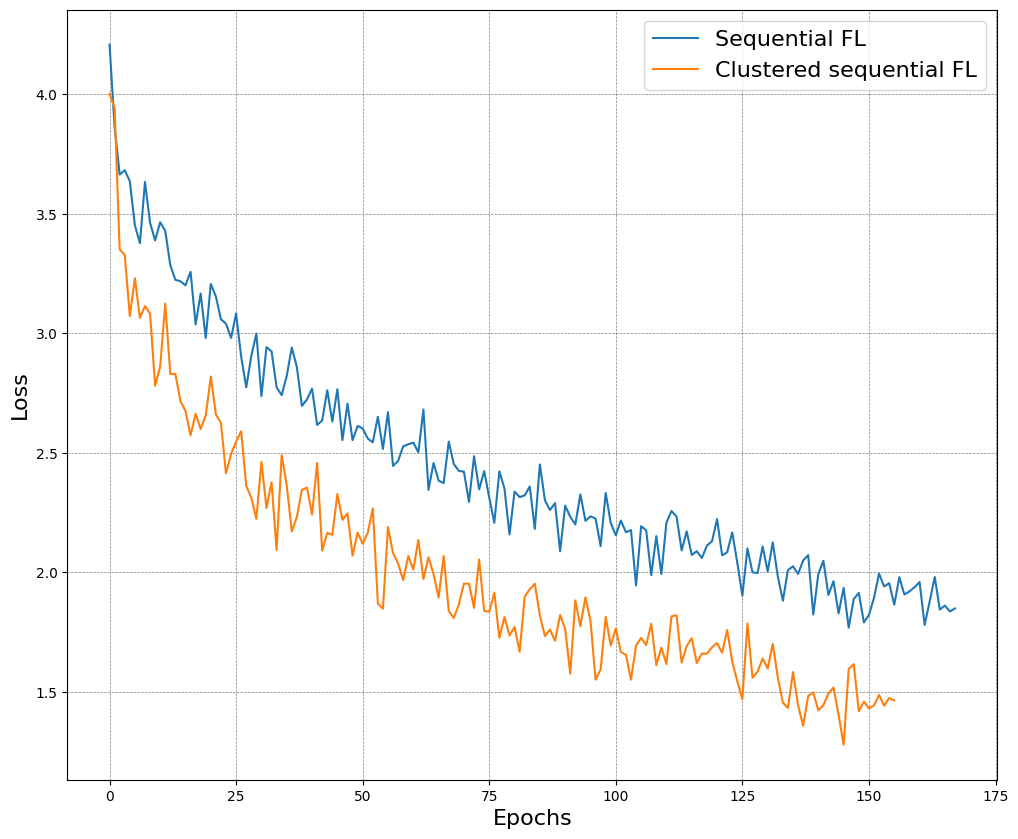

In [26]:
_, ax = plt.subplots(figsize=(12, 10))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(get_average_loss(sequential_learning_results), label='Sequential FL')
ax.plot(get_average_loss_clustered(clustered_learning_results), label='Clustered sequential FL')
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.legend(fontsize=16)
plt.show()

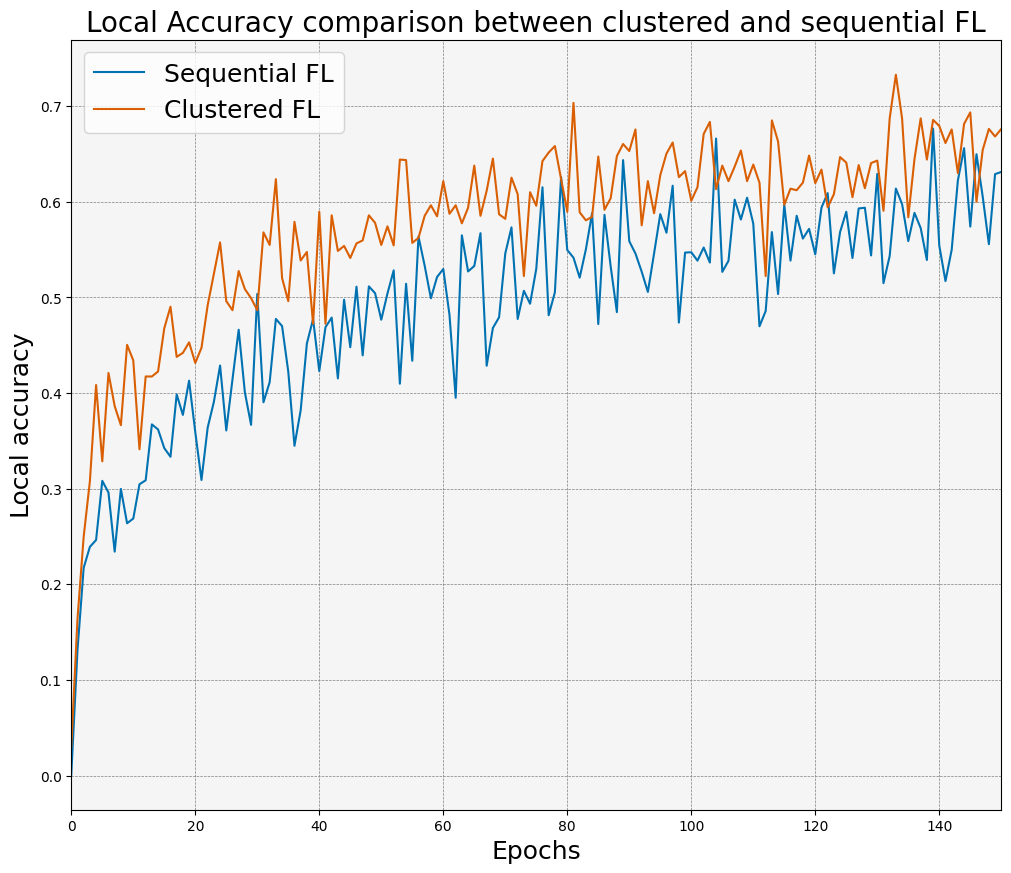

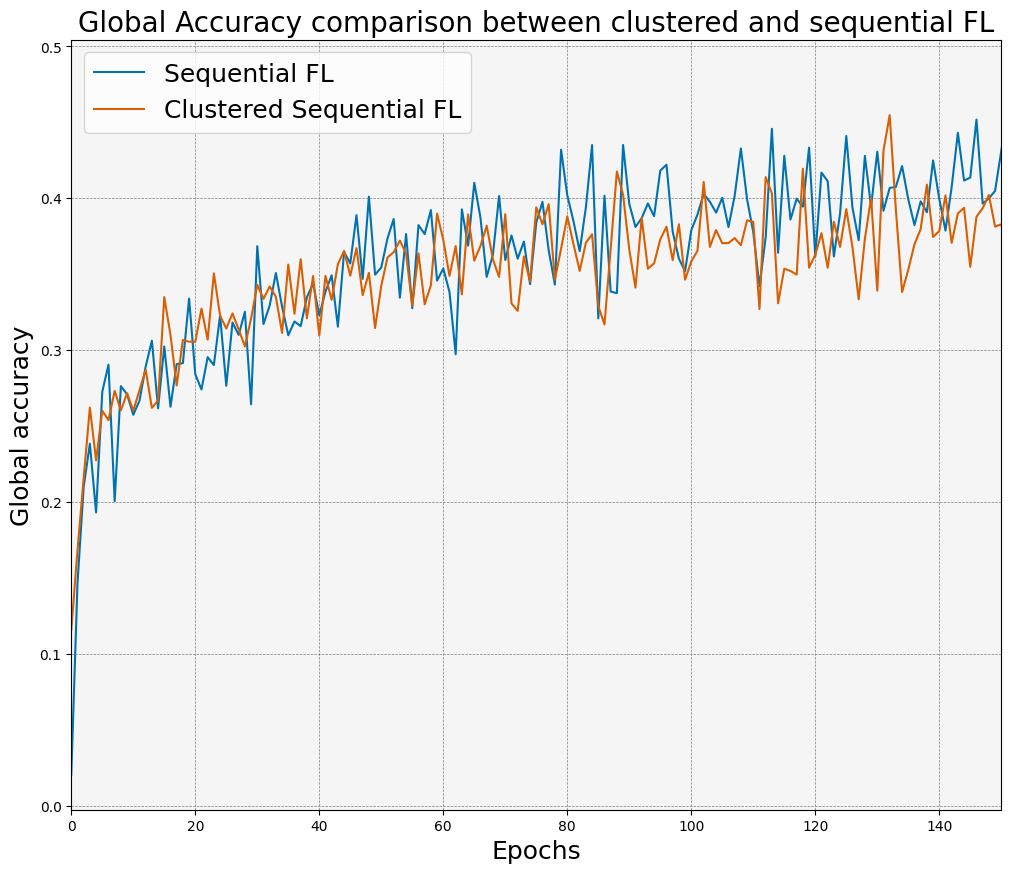

In [31]:
_, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Local Accuracy comparison between clustered and sequential FL", fontsize=20)
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(get_local_accuracy(sequential_learning_results), label="Sequential FL", color=colors["blue"])
ax.plot(get_local_accuracy_clustered(clustered_learning_results), label="Clustered FL", color=colors['orange'])
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Local accuracy", fontsize=18)
ax.legend(fontsize=18)
ax.set_xlim(0, 150)
plt.show()
_, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Global Accuracy comparison between clustered and sequential FL", fontsize=20)
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(get_average_global_accuracy_with_no_dict(sequential_learning_results), label="Sequential FL", color=colors["blue"])
ax.plot(get_average_global_accuracy_with_no_dict(clustered_learning_results), label="Clustered Sequential FL", color=colors['orange'])
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Global accuracy", fontsize=18)
ax.legend(fontsize=18)
ax.set_xlim(0, 150)
plt.show()